<a href="https://colab.research.google.com/github/bforoura/Transformers/blob/main/nlp_transformers_ch2_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Activating the GPU
# Main menu->Runtime->Change Runtime Type

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [5]:
#@title Installing the Hugging Face PyTorch Interface for Bert

!pip install -q transformers



     |████████████████████████████████| 4.9 MB 31.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 163 kB 73.0 MB/s 


In [6]:
#@title Importing the modules

import torch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup


In [7]:
from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt



In [8]:
#@title Specify CUDA as device for Torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

torch.cuda.get_device_name(0)


'Tesla T4'

In [9]:
#@title Loading the Dataset


df = pd.read_csv("https://raw.githubusercontent.com/PacktPublishing/Transformers-for-Natural-Language-Processing/main/Chapter02/in_domain_train.tsv", 
                 delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

df.shape


(8551, 4)

In [10]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5211,kl93,0,*,it 's not the case that every boy has any pota...
7043,sgww85,1,NaN,he hated himself and his friends .
6853,m_02,1,NaN,only to glasgow would he go by train .
3603,ks08,1,NaN,the piano played a song .
4807,ks08,0,*,john knows whose book mary bought and tom talk...
5474,b_73,1,NaN,what his father wants him to be is a better po...
3682,ks08,0,*,john suddenly got the bus off .
7968,ad03,0,*,who did plato listen to dp demosthenes ' orati...
4012,ks08,0,*,john made mary cooking korean food .
6377,d_98,0,*,"often , any lion is majestic ."


In [11]:
#@title Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# print 10
sentences[:10]

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up . [SEP]",
 "[CLS] one more pseudo generalization or i 'm giving up . [SEP]",
 '[CLS] the more we study verbs , the crazier they get . [SEP]',
 '[CLS] day by day the facts are getting murkier . [SEP]',
 "[CLS] i 'll fix you a drink . [SEP]",
 '[CLS] fred watered the plants flat . [SEP]',
 '[CLS] bill coughed his way out of the restaurant . [SEP]',
 "[CLS] we 're dancing the night away . [SEP]",
 '[CLS] herman hammered the metal flat . [SEP]']

In [12]:
#@title Activating the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [13]:
#@title Processing the data

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Let's look at one
input_ids[:1]


array([[  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,
         4106,  1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [14]:
#@title Create attention masks

attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [15]:
#@title Splitting data into train and validation sets

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels=train_test_split(input_ids, labels, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _= train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)



In [16]:
#@title Converting all the data into torch tensors

# Torch tensors are the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)



In [17]:
#@title Selecting a Batch Size and Creating and Iterator

# Select a batch size for training. For fine-tuning BERT on a specific task, 
# the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. 
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into  memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)






In [18]:
#@title BERT Model Configuration

from transformers import BertModel, BertConfig
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config

print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [19]:
#@title Loading Hugging Face Bert uncased base model

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.cuda()


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
#@title Optimizer Grouped Parameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    # For the 'weight' parameters, this specifies a 'weight_decay_rate' of 0.1
   {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
   
    # For the 'bias' parameters, the 'weight_decay_rate' is 0.0.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [26]:
#@title The Hyperparemeters for the Training Loop 

# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup=.1)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [27]:
#@title Creating the Accuracy Measurement Function

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))




Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5158401343090405


Epoch:  25%|██▌       | 1/4 [02:42<08:07, 162.37s/it]

Validation Accuracy: 0.8101851851851852
Train loss: 0.3172142327882937


Epoch:  50%|█████     | 2/4 [05:24<05:24, 162.40s/it]

Validation Accuracy: 0.8275462962962963
Train loss: 0.1898160049328542


Epoch:  75%|███████▌  | 3/4 [08:07<02:42, 162.42s/it]

Validation Accuracy: 0.8236882716049382
Train loss: 0.12120350116005948


Epoch: 100%|██████████| 4/4 [10:49<00:00, 162.41s/it]

Validation Accuracy: 0.8240740740740741


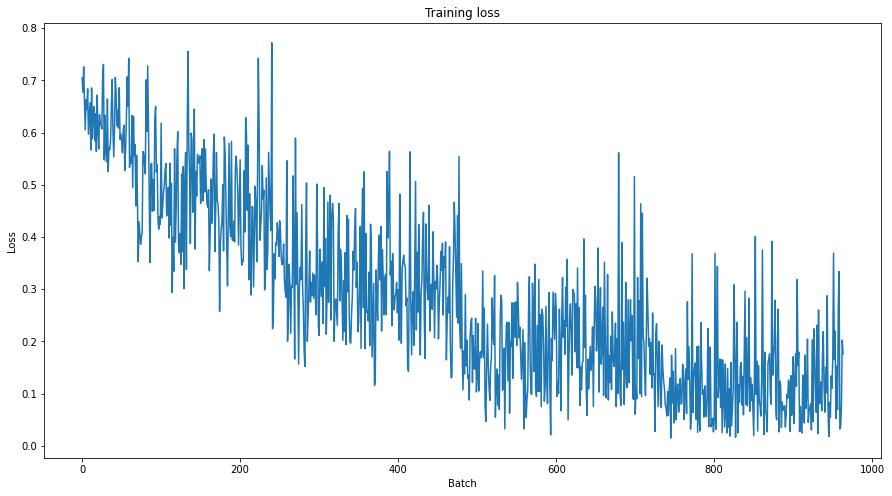

In [29]:
#@title Training Evaluation

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
